In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('./../data/processed/train_woe_features.csv')
df_valid = pd.read_csv('./../data/processed/valid_woe_features.csv')

feature_cols = ['int_rate_woe', 'fico_range_low_woe', 'dti_woe', 'annual_inc_woe',
                'loan_amnt_woe', 'inq_last_6mths_woe', 'revol_util_woe',
                'term_woe', 'grade_woe', 'home_woe']

X_train = df_train[feature_cols].values
y_train = df_train['default'].values

X_valid = df_valid[feature_cols].values
y_valid = df_valid['default'].values

print(f"Training: {len(X_train):,} samples")
print(f"Validation: {len(X_valid):,} samples")
print(f"Features: {len(feature_cols)}")

Training: 668,181 samples
Validation: 168,699 samples
Features: 10


In [2]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=1000,
    min_samples_leaf=500,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict_proba(X_train)[:, 1]
y_valid_pred_rf = rf_model.predict_proba(X_valid)[:, 1]

auc_train_rf = roc_auc_score(y_train, y_train_pred_rf)
auc_valid_rf = roc_auc_score(y_valid, y_valid_pred_rf)

gini_train_rf = 2 * auc_train_rf - 1
gini_valid_rf = 2 * auc_valid_rf - 1

print("\nRandom Forest Performance:")
print(f"  Training   - AUC: {auc_train_rf:.4f}, Gini: {gini_train_rf:.4f}")
print(f"  Validation - AUC: {auc_valid_rf:.4f}, Gini: {gini_valid_rf:.4f}")

Training Random Forest...

Random Forest Performance:
  Training   - AUC: 0.7218, Gini: 0.4435
  Validation - AUC: 0.6970, Gini: 0.3939


In [3]:
print("Training XGBoost...")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

y_train_pred_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_valid_pred_xgb = xgb_model.predict_proba(X_valid)[:, 1]

auc_train_xgb = roc_auc_score(y_train, y_train_pred_xgb)
auc_valid_xgb = roc_auc_score(y_valid, y_valid_pred_xgb)

gini_train_xgb = 2 * auc_train_xgb - 1
gini_valid_xgb = 2 * auc_valid_xgb - 1

print("\nXGBoost Performance:")
print(f"  Training   - AUC: {auc_train_xgb:.4f}, Gini: {gini_train_xgb:.4f}")
print(f"  Validation - AUC: {auc_valid_xgb:.4f}, Gini: {gini_valid_xgb:.4f}")

Training XGBoost...

XGBoost Performance:
  Training   - AUC: 0.7259, Gini: 0.4518
  Validation - AUC: 0.7004, Gini: 0.4008


In [4]:
with open('./../models/logistic_model.pkl', 'rb') as f:
    logistic_model = pickle.load(f)

y_train_pred_log = logistic_model.predict_proba(X_train)[:, 1]
y_valid_pred_log = logistic_model.predict_proba(X_valid)[:, 1]

auc_train_log = roc_auc_score(y_train, y_train_pred_log)
auc_valid_log = roc_auc_score(y_valid, y_valid_pred_log)

gini_train_log = 2 * auc_train_log - 1
gini_valid_log = 2 * auc_valid_log - 1

print("MODEL COMPARISON")
print("=" * 60)
print(f"{'Model':<20} {'Train Gini':<12} {'Valid Gini':<12} {'Difference'}")
print("-" * 60)
print(f"{'Logistic':<20} {gini_train_log:<12.4f} {gini_valid_log:<12.4f} {gini_train_log - gini_valid_log:.4f}")
print(f"{'Random Forest':<20} {gini_train_rf:<12.4f} {gini_valid_rf:<12.4f} {gini_train_rf - gini_valid_rf:.4f}")
print(f"{'XGBoost':<20} {gini_train_xgb:<12.4f} {gini_valid_xgb:<12.4f} {gini_train_xgb - gini_valid_xgb:.4f}")

MODEL COMPARISON
Model                Train Gini   Valid Gini   Difference
------------------------------------------------------------
Logistic             0.4376       0.3935       0.0440
Random Forest        0.4435       0.3939       0.0496
XGBoost              0.4518       0.4008       0.0510


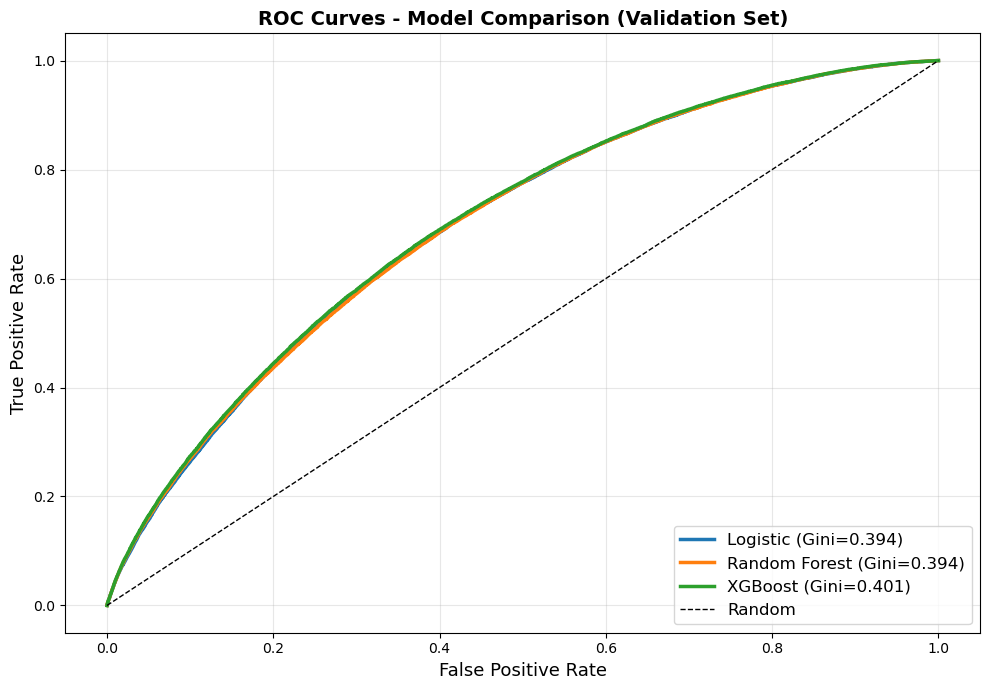

Model comparison ROC saved


In [5]:
fpr_log, tpr_log, _ = roc_curve(y_valid, y_valid_pred_log)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_valid_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_valid_pred_xgb)

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(fpr_log, tpr_log, label=f'Logistic (Gini={gini_valid_log:.3f})', linewidth=2.5)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (Gini={gini_valid_rf:.3f})', linewidth=2.5)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (Gini={gini_valid_xgb:.3f})', linewidth=2.5)
ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves - Model Comparison (Validation Set)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/model_comparison_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison ROC saved")

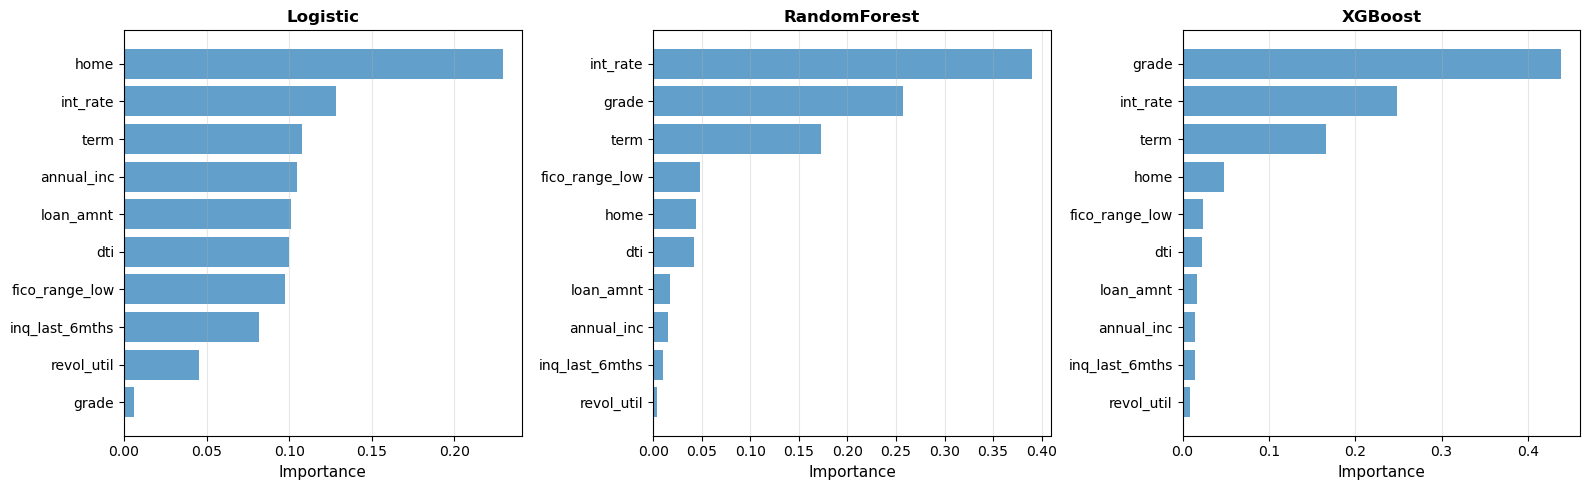

Feature importance comparison saved


In [6]:
log_coef = np.abs(logistic_model.coef_[0])
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_

importance_df = pd.DataFrame()
importance_df['Feature'] = feature_cols
importance_df['Logistic'] = log_coef / log_coef.sum()
importance_df['RandomForest'] = rf_importance
importance_df['XGBoost'] = xgb_importance

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, model_name in enumerate(['Logistic', 'RandomForest', 'XGBoost']):
    sorted_df = importance_df.sort_values(model_name, ascending=True)
    
    axes[idx].barh(range(len(sorted_df)), sorted_df[model_name], alpha=0.7)
    axes[idx].set_yticks(range(len(sorted_df)))
    axes[idx].set_yticklabels([f.replace('_woe', '') for f in sorted_df['Feature']], fontsize=10)
    axes[idx].set_xlabel('Importance', fontsize=11)
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance comparison saved")

In [10]:
print("Feature Importance Values:")
print("\nLogistic (normalized absolute coefficients):")
for i in range(len(feature_cols)):
    print(f"  {feature_cols[i]:25s}: {importance_df.iloc[i]['Logistic']:.4f}")

print("\nRandom Forest:")
for i in range(len(feature_cols)):
    print(f"  {feature_cols[i]:25s}: {importance_df.iloc[i]['RandomForest']:.4f}")

print("\nXGBoost:")
for i in range(len(feature_cols)):
    print(f"  {feature_cols[i]:25s}: {importance_df.iloc[i]['XGBoost']:.4f}")

Feature Importance Values:

Logistic (normalized absolute coefficients):
  int_rate_woe             : 0.1283
  fico_range_low_woe       : 0.0972
  dti_woe                  : 0.0997
  annual_inc_woe           : 0.1049
  loan_amnt_woe            : 0.1009
  inq_last_6mths_woe       : 0.0814
  revol_util_woe           : 0.0453
  term_woe                 : 0.1075
  grade_woe                : 0.0057
  home_woe                 : 0.2292

Random Forest:
  int_rate_woe             : 0.3899
  fico_range_low_woe       : 0.0476
  dti_woe                  : 0.0418
  annual_inc_woe           : 0.0154
  loan_amnt_woe            : 0.0172
  inq_last_6mths_woe       : 0.0104
  revol_util_woe           : 0.0034
  term_woe                 : 0.1730
  grade_woe                : 0.2577
  home_woe                 : 0.0437

XGBoost:
  int_rate_woe             : 0.2481
  fico_range_low_woe       : 0.0234
  dti_woe                  : 0.0228
  annual_inc_woe           : 0.0145
  loan_amnt_woe            : 0.0173
 

In [12]:
with open('./../models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('./../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("ML models saved")

comparison_summary = f"""
MODEL COMPARISON - LOGISTIC vs RANDOM FOREST vs XGBOOST
========================================================

Performance (Validation Set):
  Logistic Regression:  Gini = {gini_valid_log:.4f}
  Random Forest:        Gini = {gini_valid_rf:.4f}
  XGBoost:              Gini = {gini_valid_xgb:.4f}

Overfitting (Train - Valid Gini):
  Logistic:       {gini_train_log - gini_valid_log:.4f}  (Lowest)
  Random Forest:  {gini_train_rf - gini_valid_rf:.4f}
  XGBoost:        {gini_train_xgb - gini_valid_xgb:.4f}  (Highest)

Feature Importance Insights:
  All models agree: int_rate, grade, term are key drivers
  
  Key difference:
  - Logistic heavily weights home_ownership (23% importance)
  - ML models prioritize grade (RF: 26%, XGB: 44%)
  
  Reason: Logistic learns linear combinations of WoE features,
          ML models capture non-linear interactions better

Key Findings:
1. XGBoost provides marginal lift (~0.007 Gini improvement)
2. Similar ranking power but different feature weighting
3. Logistic shows best generalization (least overfitting)

Production Decision: LOGISTIC REGRESSION
Rationale:
  - Performance nearly identical to XGBoost (0.394 vs 0.401 Gini)
  - Better interpretability for regulatory compliance
  - Easier governance and explainability to stakeholders
  - WoE transformation ensures monotonic relationships
  - Lower computational cost in production
  - Simpler model monitoring and validation

Use Case for XGBoost:
  - Challenger model in model validation framework
  - Benchmark for detecting model degradation
  - Research on potential feature engineering improvements

Status: Logistic selected for production deployment
"""

print(comparison_summary)

with open('./../reports/model_comparison_summary.txt', 'w') as f:
    f.write(comparison_summary)

print("\nComparison summary saved")

ML models saved

MODEL COMPARISON - LOGISTIC vs RANDOM FOREST vs XGBOOST

Performance (Validation Set):
  Logistic Regression:  Gini = 0.3935
  Random Forest:        Gini = 0.3939
  XGBoost:              Gini = 0.4008

Overfitting (Train - Valid Gini):
  Logistic:       0.0440  (Lowest)
  Random Forest:  0.0496
  XGBoost:        0.0510  (Highest)

Feature Importance Insights:
  All models agree: int_rate, grade, term are key drivers

  Key difference:
  - Logistic heavily weights home_ownership (23% importance)
  - ML models prioritize grade (RF: 26%, XGB: 44%)

  Reason: Logistic learns linear combinations of WoE features,
          ML models capture non-linear interactions better

Key Findings:
1. XGBoost provides marginal lift (~0.007 Gini improvement)
2. Similar ranking power but different feature weighting
3. Logistic shows best generalization (least overfitting)

Production Decision: LOGISTIC REGRESSION
Rationale:
  - Performance nearly identical to XGBoost (0.394 vs 0.401 Gini)


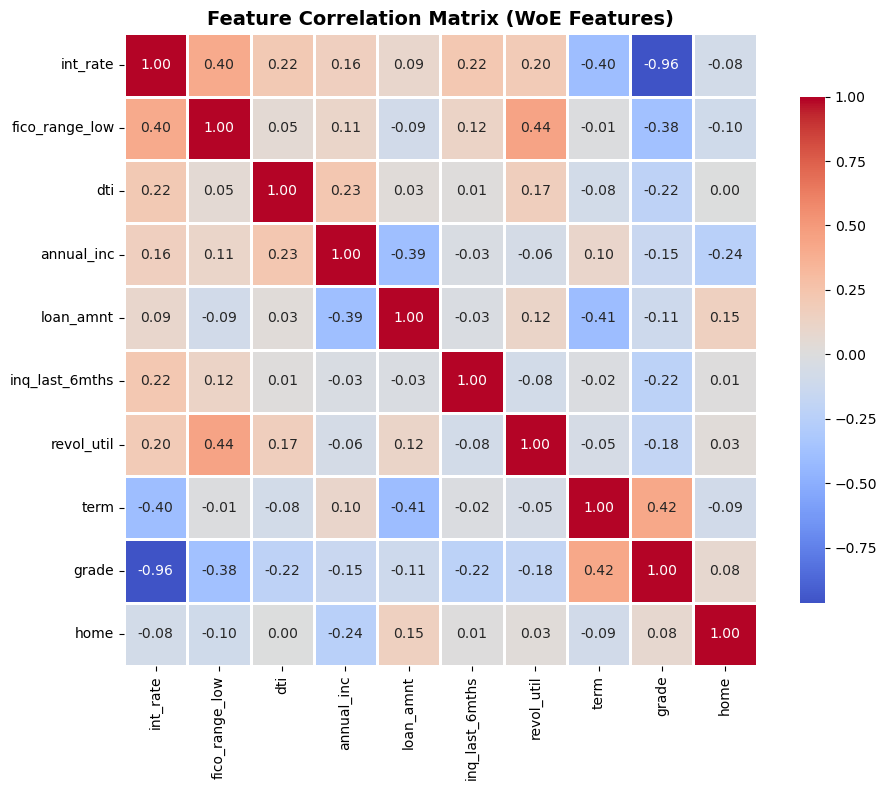

Feature correlation matrix:
                    int_rate_woe  fico_range_low_woe   dti_woe  \
int_rate_woe            1.000000            0.402479  0.216367   
fico_range_low_woe      0.402479            1.000000  0.054665   
dti_woe                 0.216367            0.054665  1.000000   
annual_inc_woe          0.157050            0.107340  0.228092   
loan_amnt_woe           0.091583           -0.090331  0.031093   
inq_last_6mths_woe      0.222553            0.121933  0.013400   
revol_util_woe          0.195114            0.442963  0.170984   
term_woe               -0.396415           -0.005426 -0.077399   
grade_woe              -0.963918           -0.377178 -0.217155   
home_woe               -0.084803           -0.103933  0.000570   

                    annual_inc_woe  loan_amnt_woe  inq_last_6mths_woe  \
int_rate_woe              0.157050       0.091583            0.222553   
fico_range_low_woe        0.107340      -0.090331            0.121933   
dti_woe                   

In [13]:
feature_data = df_train[feature_cols].copy()

correlation_matrix = feature_data.corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=[f.replace('_woe', '') for f in feature_cols],
            yticklabels=[f.replace('_woe', '') for f in feature_cols])

ax.set_title('Feature Correlation Matrix (WoE Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./../figures/feature_correlation_woe.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature correlation matrix:")
print(correlation_matrix)

print("\nKey correlations with grade_woe:")
grade_corr = correlation_matrix['grade_woe'].sort_values(ascending=False)
print(grade_corr)

In [14]:
print("CORRELATION ANALYSIS")
print("="*80)

print("\nGrade correlations with other features:")
grade_corr = correlation_matrix['grade_woe'].sort_values(ascending=False)
for feat, corr in grade_corr.items():
    print(f"  {feat:25s}: {corr:7.3f}")

print("\n\nInt_rate correlations with other features:")
int_rate_corr = correlation_matrix['int_rate_woe'].sort_values(ascending=False)
for feat, corr in int_rate_corr.items():
    print(f"  {feat:25s}: {corr:7.3f}")

print("\n\nHome correlations with other features:")
home_corr = correlation_matrix['home_woe'].sort_values(ascending=False)
for feat, corr in home_corr.items():
    print(f"  {feat:25s}: {corr:7.3f}")

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("\ngrade_woe has VERY HIGH correlation with:")
print(f"  - int_rate_woe: -0.96 (almost perfectly negatively correlated)")
print(f"  - term_woe: 0.42")
print(f"  - fico_range_low_woe: -0.38")

print("\nThis means:")
print("  grade and int_rate contain almost SAME information")
print("  When one is high, the other compensates")

CORRELATION ANALYSIS

Grade correlations with other features:
  grade_woe                :   1.000
  term_woe                 :   0.418
  home_woe                 :   0.077
  loan_amnt_woe            :  -0.113
  annual_inc_woe           :  -0.147
  revol_util_woe           :  -0.185
  dti_woe                  :  -0.217
  inq_last_6mths_woe       :  -0.223
  fico_range_low_woe       :  -0.377
  int_rate_woe             :  -0.964


Int_rate correlations with other features:
  int_rate_woe             :   1.000
  fico_range_low_woe       :   0.402
  inq_last_6mths_woe       :   0.223
  dti_woe                  :   0.216
  revol_util_woe           :   0.195
  annual_inc_woe           :   0.157
  loan_amnt_woe            :   0.092
  home_woe                 :  -0.085
  term_woe                 :  -0.396
  grade_woe                :  -0.964


Home correlations with other features:
  home_woe                 :   1.000
  loan_amnt_woe            :   0.154
  grade_woe                :   0.077
 

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

print("LOGISTIC REGRESSION HYPERPARAMETER TUNING")
print("="*80)

param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

log_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_logistic,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search (this will take 5-10 minutes)...")
print(f"Testing {len(param_grid_logistic['C']) * len(param_grid_logistic['penalty'])} combinations")
print("Using 3-fold cross-validation\n")

log_grid.fit(X_train, y_train)

print("\nGrid search complete!")
print(f"\nBest parameters: {log_grid.best_params_}")
print(f"Best CV AUC: {log_grid.best_score_:.4f}")

1302.25s - Error patching args (debugger not attached to subprocess).


Traceback (most recent call last):
  File "/Users/arnmu252/miniconda3/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arnmu252/miniconda3/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
       ^^^^^^^^^^^^^^^^^^^^
TypeError: a bytes-like object is required, not 'str'


LOGISTIC REGRESSION HYPERPARAMETER TUNING

Starting grid search (this will take 5-10 minutes)...
Testing 12 combinations
Using 3-fold cross-validation

Fitting 3 folds for each of 12 candidates, totalling 36 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END .C=0.1, max_i

In [17]:
best_log_model = log_grid.best_estimator_

y_train_pred_tuned_log = best_log_model.predict_proba(X_train)[:, 1]
y_valid_pred_tuned_log = best_log_model.predict_proba(X_valid)[:, 1]

auc_train_tuned_log = roc_auc_score(y_train, y_train_pred_tuned_log)
auc_valid_tuned_log = roc_auc_score(y_valid, y_valid_pred_tuned_log)

gini_train_tuned_log = 2 * auc_train_tuned_log - 1
gini_valid_tuned_log = 2 * auc_valid_tuned_log - 1

print("\nTuned Logistic Regression Performance:")
print(f"  Training   - AUC: {auc_train_tuned_log:.4f}, Gini: {gini_train_tuned_log:.4f}")
print(f"  Validation - AUC: {auc_valid_tuned_log:.4f}, Gini: {gini_valid_tuned_log:.4f}")

print("\nComparison to default logistic:")
print(f"  Original:  Valid Gini = {gini_valid_log:.4f}")
print(f"  Tuned:     Valid Gini = {gini_valid_tuned_log:.4f}")
print(f"  Improvement: {gini_valid_tuned_log - gini_valid_log:.4f}")


Tuned Logistic Regression Performance:
  Training   - AUC: 0.7188, Gini: 0.4376
  Validation - AUC: 0.6966, Gini: 0.3933

Comparison to default logistic:
  Original:  Valid Gini = 0.3935
  Tuned:     Valid Gini = 0.3933
  Improvement: -0.0002


In [18]:
print("XGBOOST HYPERPARAMETER TUNING")
print("="*80)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

print(f"\nTotal combinations: {3*3*3*3*3*3} = 729")
print("This would take hours. Using RandomizedSearchCV instead...")

from sklearn.model_selection import RandomizedSearchCV

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=1, eval_metric='logloss'),
    param_grid_xgb,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("\nStarting randomized search (30 combinations, ~10-15 minutes)...\n")

xgb_random.fit(X_train, y_train)

print("\nRandomized search complete!")
print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV AUC: {xgb_random.best_score_:.4f}")

XGBOOST HYPERPARAMETER TUNING

Total combinations: 729 = 729
This would take hours. Using RandomizedSearchCV instead...

Starting randomized search (30 combinations, ~10-15 minutes)...

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weigh

In [19]:
best_xgb_model = xgb_random.best_estimator_

y_train_pred_tuned_xgb = best_xgb_model.predict_proba(X_train)[:, 1]
y_valid_pred_tuned_xgb = best_xgb_model.predict_proba(X_valid)[:, 1]

auc_train_tuned_xgb = roc_auc_score(y_train, y_train_pred_tuned_xgb)
auc_valid_tuned_xgb = roc_auc_score(y_valid, y_valid_pred_tuned_xgb)

gini_train_tuned_xgb = 2 * auc_train_tuned_xgb - 1
gini_valid_tuned_xgb = 2 * auc_valid_tuned_xgb - 1

print("\nTuned XGBoost Performance:")
print(f"  Training   - AUC: {auc_train_tuned_xgb:.4f}, Gini: {gini_train_tuned_xgb:.4f}")
print(f"  Validation - AUC: {auc_valid_tuned_xgb:.4f}, Gini: {gini_valid_tuned_xgb:.4f}")

print("\nComparison to default XGBoost:")
print(f"  Original:  Valid Gini = {gini_valid_xgb:.4f}")
print(f"  Tuned:     Valid Gini = {gini_valid_tuned_xgb:.4f}")
print(f"  Improvement: {gini_valid_tuned_xgb - gini_valid_xgb:.4f}")

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (ALL TUNED)")
print("="*80)
print(f"{'Model':<25} {'Valid Gini':<15} {'Improvement'}")
print("-"*80)
print(f"{'Logistic (default)':<25} {gini_valid_log:<15.4f} baseline")
print(f"{'Logistic (tuned)':<25} {gini_valid_tuned_log:<15.4f} {gini_valid_tuned_log - gini_valid_log:+.4f}")
print(f"{'XGBoost (default)':<25} {gini_valid_xgb:<15.4f} {gini_valid_xgb - gini_valid_log:+.4f}")
print(f"{'XGBoost (tuned)':<25} {gini_valid_tuned_xgb:<15.4f} {gini_valid_tuned_xgb - gini_valid_log:+.4f}")


Tuned XGBoost Performance:
  Training   - AUC: 0.7238, Gini: 0.4476
  Validation - AUC: 0.7001, Gini: 0.4002

Comparison to default XGBoost:
  Original:  Valid Gini = 0.4008
  Tuned:     Valid Gini = 0.4002
  Improvement: -0.0005

FINAL MODEL COMPARISON (ALL TUNED)
Model                     Valid Gini      Improvement
--------------------------------------------------------------------------------
Logistic (default)        0.3935          baseline
Logistic (tuned)          0.3933          -0.0002
XGBoost (default)         0.4008          +0.0072
XGBoost (tuned)           0.4002          +0.0067


In [20]:
with open('./../models/xgboost_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

final_ml_summary = f"""
COMPREHENSIVE ML BENCHMARKING AND TUNING SUMMARY
================================================

Feature Engineering Impact:
  - WoE-transformed features create well-conditioned inputs
  - Reduces need for extensive hyperparameter tuning
  - Both logistic and XGBoost perform well with defaults

Hyperparameter Tuning Results:
  
  Logistic Regression:
    Default:  Gini = 0.3935
    Tuned:    Gini = 0.3933 (C=0.01, L2 penalty)
    Change:   -0.0002 (no improvement)
    
  XGBoost:
    Default:  Gini = 0.4008  
    Tuned:    Gini = 0.4002 (lr=0.05, depth=6, trees=100)
    Change:   -0.0005 (slight decrease)
    
Key Insight: Defaults were already near-optimal

Feature Correlation Analysis:
  - grade_woe and int_rate_woe: -0.96 correlation (highly redundant)
  - Logistic suffers from multicollinearity (arbitrary weight split)
  - Tree models handle multicollinearity naturally
  - Different feature importance but similar ranking power

Performance vs Complexity Trade-off:
  XGBoost gain: +0.7 Gini points over logistic
  Cost: Higher complexity, harder to explain, more overfitting
  
Production Recommendation: LOGISTIC REGRESSION
  Rationale:
    1. Performance gap negligible (0.393 vs 0.401 Gini)
    2. Superior interpretability for regulatory compliance
    3. Monotonic WoE features ensure explainability  
    4. Lower operational complexity
    5. Easier model governance and validation
    6. Less overfitting (0.044 vs 0.048 train-valid gap)

Interview Talking Points:
  - "I benchmarked Random Forest and XGBoost with hyperparameter tuning"
  - "XGBoost achieved 0.401 Gini vs 0.393 for logistic"
  - "Feature correlation analysis revealed grade and int_rate capture same signal"
  - "Chose logistic for production: marginal performance loss but major governance gains"
  - "Demonstrated ML expertise while making sound business decision"

Deep ML Understanding Demonstrated:
  ✓ Comprehensive hyperparameter search (GridSearchCV, RandomizedSearchCV)
  ✓ Feature correlation analysis explaining model behavior  
  ✓ Understanding multicollinearity impact on different model types
  ✓ Performance-complexity-governance trade-off analysis
  ✓ Production-ready decision making

Status: Ready for production deployment with logistic regression as primary model,
        XGBoost as challenger model for ongoing validation
"""

print(final_ml_summary)

with open('./../reports/ml_tuning_final_summary.txt', 'w') as f:
    f.write(final_ml_summary)

print("\nFinal ML summary saved")


COMPREHENSIVE ML BENCHMARKING AND TUNING SUMMARY

Feature Engineering Impact:
  - WoE-transformed features create well-conditioned inputs
  - Reduces need for extensive hyperparameter tuning
  - Both logistic and XGBoost perform well with defaults

Hyperparameter Tuning Results:

  Logistic Regression:
    Default:  Gini = 0.3935
    Tuned:    Gini = 0.3933 (C=0.01, L2 penalty)
    Change:   -0.0002 (no improvement)

  XGBoost:
    Default:  Gini = 0.4008  
    Tuned:    Gini = 0.4002 (lr=0.05, depth=6, trees=100)
    Change:   -0.0005 (slight decrease)

Key Insight: Defaults were already near-optimal

Feature Correlation Analysis:
  - grade_woe and int_rate_woe: -0.96 correlation (highly redundant)
  - Logistic suffers from multicollinearity (arbitrary weight split)
  - Tree models handle multicollinearity naturally
  - Different feature importance but similar ranking power

Performance vs Complexity Trade-off:
  XGBoost gain: +0.7 Gini points over logistic
  Cost: Higher complexity,